<img src='images/Northwind_ERD_updated.png.'>

<a href='#1.0-Initial-Question'>**1.0 Initial Question**</a>

<a href='#1.1-Initial-Hypothesis'>**1.1 Initial Hypothesis**</a>
- <a href='#1.1.1-Null-Hypothesis'>1.1.1 Null Hypothesis</a>
- <a href='#1.1.2-Alternative-Hypothesis'>1.1.2 Alternative Hypothesis</a>
- <a href='#1.1.3-Features'>1.1.3 Features</a>
- <a href='#1.1.4-Target-Variable'>1.1.4 Target Variable</a>

<a href='#1.2-Methodology'>**1.2 Methodology**</a>
- <a href='#1.2.1-Obtain-Data'>1.2.1 Obtain Data</a>
- <a href='#1.2.2-Scrub-Data'>1.2.2 Scrub Data</a>
    - <a href='#1.2.2.1-Manage-n/a-data-types'>1.2.2.1 Manage n/a data types</a>
    - <a href='#1.2.2.2-Remove-duplicate-data'>1.2.2.2 Remove duplicate data</a>
    - <a href='#1.2.2.3-Manage-data-types'>1.2.2.3 Manage data types</a>
    - <a href='#1.2.2.4-Remove-outliers'>1.2.2.4 Remove outliers</a>
- <a href='#1.2.3-Explore-Data'>1.2.3 Explore Data</a>
    - <a href='#1.2.3.1-Visualize-data'>1.2.3.1 Visualize data</a>
    - <a href='#1.2.3.2-Transform-data'>1.2.3.2 Transform data</a>
    - <a href='#1.2.3.3-Sort-data-/-Prepare-data-for-testing'>1.2.3.3 Sort data / Prepare data for testing</a>
    - <a href='#1.2.3.4-Develop-feature'>1.2.3.4 Develop Feature</a>
- <a href='#1.2.4-Model-Data'>1.2.4 Model Data</a>
    - <a href='#1.2.4.1-Check-for-data-normality'>1.2.4.1 Check for data normality</a>
    - <a href='#1.2.4.2-Standard-deviation-and-other-basic-statistics'>1.2.4.2 Standard deviation and other basic statistics</a>
    - <a href='#1.2.4.3-Statistical-test'>1.2.4.3 Statistical test</a>
    - <a href='#1.2.4.4-Verification-techniques'>1.2.4.4 Verification techniques</a>
        - <a href='#1.2.4.4.1-Nonparametric-testing-and-confirmatory-testing'>1.2.4.4.1 Nonparametric testing</a>
        - <a href='#1.2.4.4.2-Effect-size'>1.2.4.4.2 Effect size</a>
        - <a href='#1.2.4.4.3-Error'>1.2.4.4.3 Error</a>
- <a href='#1.2.5-Interpret-Model'>1.2.5 Interpret Model</a>
    - <a href='#1.2.5.1-Extension-of-acquired-knowledge'>1.2.5.1 Extension of acquired knowledge</a>
    
<a href='#1.3-Results'>**1.3 Results**</a>

<a href='#1.4-Conclusions'>**1.4 Conclusions**</a>

- <a href='#1.4.1-Actionable-Items-and-Insights'>1.4.1 Actionable Items and Insights</a>
- <a href='#1.4.2-Additional-Visuals'>1.4.2 Additional Visuals</a>

<a href='#1.5-Future-Work'>**1.5 Future Work**</a>

<a href='#1.6-References'>**1.6 References**</a>

# 1.0 Initial Question<a id='Initial Question'></a>

### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

# 1.1 Initial Hypothesis<a id='Initial Hypothesis'></a>

### 1.1.1 Null Hypothesis<a id='Null Hypothesis'></a>

H0: no effect - **discount** has no effect on **quantity** of a **product** in an **order**.

The bolded items in the H0 statement represent the data that needs to be pulled down from the database. 

### 1.1.2 Alternative Hypothesis<a id='Alternative Hypothesis'></a>

HA: effect - discount has statistically significant effect on quantity of a product in an order.

### 1.1.3 Features<a id='Features'></a>

Discount

### 1.1.4 Target Variable<a id='Target Variable'></a>

Quantity

# 1.2 Methodology<a id='Methodology'></a>

To evaluate the data provided by Northwind_ERD, I have chosen to use the following steps:
- 1.2.1 Obtain Data
- 1.2.2 Scrub Data
- 1.2.3 Explore Data
- 1.2.4 Model Data
- 1.2.5 Interpret Model

I have found that the OSEMN method explains the data science process, and gives context to exploring data.


## 1.2.1 Obtain Data<a id='Obtain Data'></a>

The data we're evaluating comes from the 'Northwind_small.sqlite' file in this repository. We'll need to pull the following tables and the following lines of information:

- OrderDetail
    - OrderId
    - ProductId
    - UnitPrice
    - Quantity

In [1]:
# import py file
from classes import Pvalue

In [2]:
# import libraries
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# connect to database
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [4]:
#what tables are available in the database
cur.execute("""SELECT name 
               FROM sqlite_master
               WHERE type = 'table';""")
cur.fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [5]:
# OrderDetail data
cur.execute("""SELECT *
               FROM OrderDetail
               """)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


## 1.2.2 Scrub Data<a id='Scrub Data'></a>

The following scrubbing techniques were applied to the original data:
- 1.2.2.1 Manage n/a data types
- 1.2.2.2 Remove duplicate rows
- 1.2.2.3 Manage data types
- 1.2.2.4 Remove outliers

### 1.2.2.1 Manage n/a data types<a id='Manage n/a data types'></a>

In [6]:
# nans identification
print(len(df))
df.isna().sum()

2155


Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

### 1.2.2.2 Remove duplicate data<a id='Remove duplicate data'></a>

In [7]:
# identification of duplicate data
print('duplicated rows: ' + str(df.duplicated().sum()))

duplicated rows: 0


In [8]:
# code to drop duplicate rows if necessary
# df.drop_duplicates(inplace=True)
# print('duplicated rows: ' + str(df.duplicated().sum()))

### 1.2.2.3 Manage data types<a id='Manage data types'></a>

In [9]:
# data type identification
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


### 1.2.2.4 Remove outliers<a id='Remove outliers'></a>

In [10]:
df['Discount'].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [11]:
df_discount_0_01 = df[df['Discount']==0.01]
df_discount_0_01

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2152,11077/73,11077,73,15.0,2,0.01


In [12]:
df_discount_0_02 = df[df['Discount']==0.02]
df_discount_0_02

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2133,11077/6,11077,6,25.0,1,0.02
2146,11077/46,11077,46,12.0,3,0.02


In [13]:
df_discount_0_03 = df[df['Discount']==0.03]
df_discount_0_03

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2139,11077/14,11077,14,23.25,1,0.03
2140,11077/16,11077,16,17.45,2,0.03
2150,11077/64,11077,64,33.25,2,0.03


In [14]:
df_discount_0_04 = df[df['Discount']==0.04]
df_discount_0_04

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2141,11077/20,11077,20,81.0,1,0.04


In [15]:
df_discount_0_06 = df[df['Discount']==0.06]
df_discount_0_06

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2149,11077/60,11077,60,34.0,2,0.06


In [16]:
# percentange of rows of data where "off" percentages were referenced
8/len(df['Discount'])

0.0037122969837587007

After some exploration, we decided to drop order number 11077. It has a bunch of off percentages that were used only for that order, including a 1, 2, 3, 4, and 6 percent discount for one, two, or three items. Additionally, this dropped data is less than 1% percent of all data included.

In [17]:
df = df[df['OrderId']!=11077]
df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2125,11075/46,11075,46,12.00,30,0.15
2126,11075/76,11075,76,18.00,2,0.15
2127,11076/6,11076,6,25.00,20,0.25
2128,11076/14,11076,14,23.25,20,0.25


## 1.2.3 Explore Data<a id='Explore Data'></a>

For a quick preview of what we have to work with, we'll use the describe method.

- 1.2.3.1 Visualize data
- 1.2.3.2 Transform data
- 1.2.3.3 Sort data / Prepare data for testing
- 1.2.3.4 Develop Feature

### 1.2.3.1 Visualize data<a id='Visualize data'></a>

In [18]:
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2130.000000,2130.000000,2130.000000,2130.000000,2130.000000
mean,10654.474178,40.887793,26.256601,24.058685,0.056502
std,238.485752,22.099737,29.952802,18.990859,0.083749
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10448.250000,22.000000,12.000000,10.000000,0.000000
50%,10653.000000,41.000000,18.400000,20.000000,0.000000
75%,10856.000000,60.000000,32.000000,30.000000,0.100000
max,11076.000000,77.000000,263.500000,130.000000,0.250000


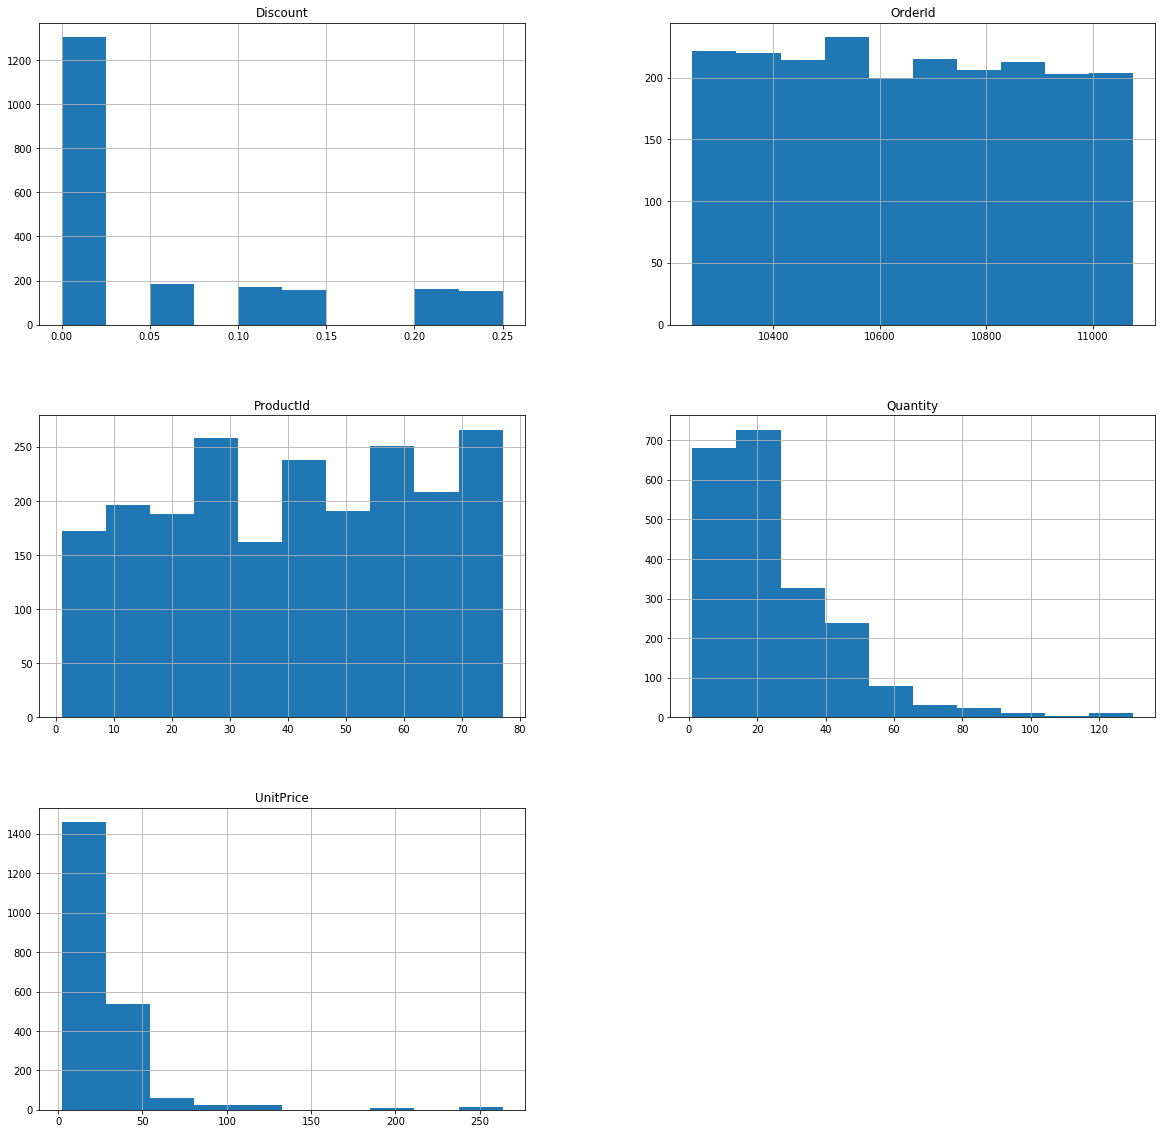

In [19]:
df.hist(figsize=(20,20));

### 1.2.3.2 Transform data<a id='Transform data'></a>

### 1.2.3.3 Sort data / Prepare data for testing<a id='Sort data'></a>

In [20]:
# sort data
pass

### 1.2.3.4 Develop feature<a id='Develop feature'></a>

In [21]:
pass

## 1.2.4 Model Data<a id='Model Data'></a>

2 Sample T-Test

- 1.2.4.1 Check for data normality
- 1.2.4.2 Standard deviation and other basic statistics
- 1.2.4.3 Statistical test
- 1.2.4.4 Verification techniques

### 1.2.4.1 Check for data normality<a id='Data normality'></a>

### 1.2.4.2 Standard deviation and other basic statistics<a id='Standard deviation'></a>

### 1.2.4.3 Statistical test<a id='Statistical test'></a>

In [22]:
# calculating the t statistic (doing on 'paper' to confirm that the data is organized correctly before running test)
alpha = 0.05
x_bar_no_discount = df[df['Discount']==0]['Quantity'].mean()
x_bar_discount = df[df['Discount']!=0]['Quantity'].mean()
sigma_no_discount = df[df['Discount']==0]['Quantity'].std()
sigma_discount = df[df['Discount']!=0]['Quantity'].std()
n_no_discount = len(df[df['Discount']==0]['Quantity'])
n_discount = len(df[df['Discount']!=0]['Quantity'])
mu_discount = mu_no_discount = 100
dof = n_discount - 1
t = ((x_bar_no_discount-x_bar_discount) - (mu_no_discount-mu_discount)) / np.sqrt((sigma_no_discount**2/n_no_discount) + (sigma_discount**2/n_discount))
t

-6.435470210648312

In [23]:
# test
statistic, pvalue = stats.ttest_ind(df[df['Discount']==0]['Quantity'], df[df['Discount']!=0]['Quantity'])
pvalue

2.978795042135765e-11

In [24]:
# evaluation of results
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


This means means that discount has a statistically significant effect on quantity of a product in an order, tentatively. This needs to be explored a little bit further to verify that this is the case, and that our results are valid. To verfiy results, we'll run a Mann Whitney to ensure that this is the case for non-parametric data as well. Our histograms for quantity were skewed right, so there is a chance that the data is non-paramentric. Then we will run a test on effect size to ensure that we have enough data points to declare statistical significance.

### 1.2.4.4 Verification techniques<a id='Verification techniques'></a>

#### 1.2.4.4.1 Nonparametric testing and confirmatory testing<a id='Nonparametric testing'></a>
Mann Whitney Test

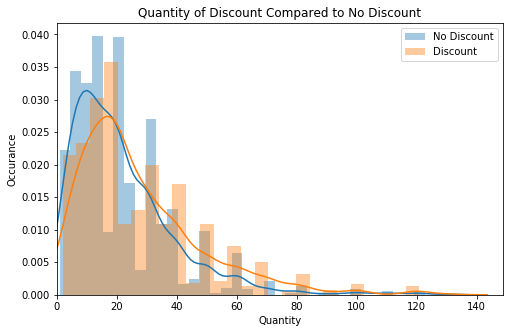

In [25]:
# visualizing the data
fig03 = plt.figure(figsize=(8,5))
ax = fig03.add_subplot(111)
ax.axes.set_title('Quantity of Discount Compared to No Discount')
ax.axes.set_ylabel('Occurance')
ax.axes.set_xlabel('Quantity')
ax1 = sns.distplot(df[df['Discount']==0]['Quantity'], label=('No Discount'), ax=ax).set_xlim(0)
ax2 = sns.distplot(df[df['Discount']!=0]['Quantity'], label=('Discount'), ax=ax).set_xlim(0)
ax.axes.legend();

In [26]:
# mann whitney test
statistice, pvalue = stats.mannwhitneyu(df[df['Discount']==0]['Quantity'], df[df['Discount']!=0]['Quantity'])
pvalue

8.339491776417814e-12

In [27]:
# evaluating the result
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


This confirms that even with non-parametric data, the same rejection of the null hypothesis is in place, meaning that the availablity of a discount affects quantity ordered. Now to see how large the impact of a discount is. Then to see how many samples are needed to ensure valid results.


#### 1.2.4.4.2 Effect size<a id='Effect size'></a>
Cohen's D

In [28]:
def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)
effect_size = cohen_d_two_samp(df[df['Discount']==0]['Quantity'], df[df['Discount']!=0]['Quantity'])
effect_size

-0.29725796307085034

This Cohen's D value actually is very low. There a very small affect of discount on quantity of products purchased.

#### 1.2.4.4.3 Error<a id='Error'></a>

Type 1

Type 2

In [30]:
# prepping variables
effect_size, nobs1, alpha = effect_size, df[df['Discount']==0]['Quantity'].shape[0], alpha

In [31]:
# power test
power = tt_ind_solve_power(effect_size=effect_size, nobs1=nobs1, alpha=alpha)
power

1.0

In [32]:
# results
type_2_error = 1 - power
type_2_error

0.0

## 1.2.5 Interpret Model<a id='Interpret Model'></a>

### 1.2.5.1 Extension of acquired knowledge<a id='Extension'></a>

#### Deeper question
#### Hypothesis for deeper question
## One Way ANOVA

### H0: quantity of order is not affected by discount size, meaning all discounts for quantity ordered are the same
### HA: quantity of order is affected by discount size, meaning at least one discount impacts quantity ordered

### Looking at the necessary data to identify discount levels

A small note about the decision to drop order# 11077 from the dataset to remove the 1, 2, 3, 4, and 6 percent discounts.

In [33]:
# discount amount reminder from original data
cur.execute("""SELECT DISTINCT(Discount)
               FROM OrderDetail
               """)
df_distint_discount = pd.DataFrame(cur.fetchall())
df_distint_discount.columns = [x[0] for x in cur.description]
df_distint_discount['Discount']

0     0.00
1     0.15
2     0.05
3     0.20
4     0.25
5     0.10
6     0.02
7     0.03
8     0.04
9     0.06
10    0.01
Name: Discount, dtype: float64

In [34]:
# variables are prepped from the original data frame
anova_df = df[df['Discount']!=0]
anova_df.head(15)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05
12,10252/33,10252,33,2.0,25,0.05
17,10254/24,10254,24,3.6,15,0.15
18,10254/55,10254,55,19.2,21,0.15
29,10258/2,10258,2,15.2,50,0.20
30,10258/5,10258,5,17.0,65,0.20


In [35]:
# ANOVA test
anova_results = sm.stats.anova_lm(ols('Quantity ~ Discount', data=anova_df).fit())
anova_results

,df,sum_sq,mean_sq,F,PR(>F)
Discount,1.0,18.503014,18.503014,0.043107,0.835576
Residual,823.0,353261.492138,429.236321,NaN,NaN


In [36]:
# results
pvalue = anova_results.loc['Discount', 'PR(>F)']

In [37]:
# evaluating results
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


Due to the ANOVA test, quantity of order is not affected by discount size. This means that overall, just by offering a discount at all quantity of the products ordered will increase. But it does not seem that offering larger discounts incentivizes increased spending by increasing the quantities ordered.

# 1.3 Results<a id='Results'></a>

# 1.4 Conclusions<a id='Conclusions'></a>

- 1.4.1 Actionable Items and Insights
- 1.4.2 Additional Visuals

## 1.4.1 Actionable Items and Insights<a id='Actionable Items and Insights'></a>

It might be wise to offer more customers smaller discounts to increased quantities of products in orders. Do note that this impact while present, will not be large. I would look for additional ways to increase customer spending in addition to offering smaller discounts to a wider range of customers. 

## 1.4.2 Additional Visuals<a id='Additional Visuals'></a>

C:\Users\eannefawcett\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


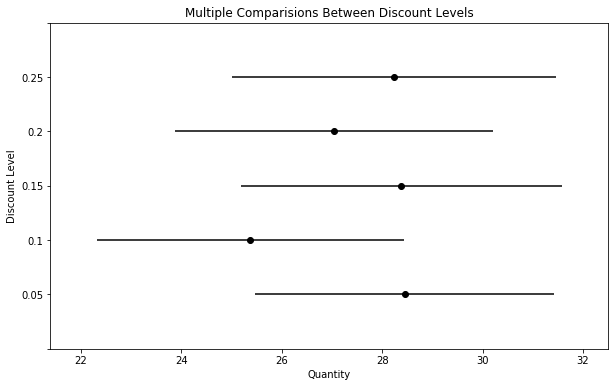

In [38]:
# visual of no differences

# create figure
fig04 = plt.figure(figsize=(5,4))
ax = fig04.add_subplot(111)

# run tukeys
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(anova_df['Quantity'], anova_df['Discount'])
tukey_plot = tukey_results.plot_simultaneous(ax=ax).show() 

# format plot
ax.axes.set_title('Multiple Comparisions Between Discount Levels')
ax.axes.set_ylabel('Discount Level')
ax.axes.set_xlabel('Quantity')
plt.show();

# 1.5 Future Work<a id='Future Work'></a>
Possibly look at discounts for high quantities of products.

# 1.6 References<a id='References'></a>